In [1]:
## Standard libraries
import os
import random
import time
import datetime
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## Progress bar
from tqdm.notebook import tqdm

## Pytorch & Torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.optim import Adam, SGD
from torch.utils.data import Dataset
from torchvision import transforms, utils
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

## Custom dataset
from CustomData import BinaryDataset
CSV_path =  '.\\'
indim = 128

In [2]:
# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
#Set seed
set_seed(42)

In [3]:
#GPU check and setup
if torch.cuda.is_available():
    torch.backends.cudnn.determinstic = True
    torch.backends.cudnn.benchmark = False
    
#Check for cuda GPU to run on:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
if gpu_avail:
    print("Device name: " + torch.cuda.get_device_name(0))

Is the GPU available? True
Device: cuda
Device name: NVIDIA GeForce GTX 1650


In [4]:
# Calc mean and std

test_transform =  transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((indim,indim)),
                                      transforms.ToTensor(),
                                     ])

dataset = BinaryDataset(csv_file = CSV_path+"frontVSprofile.csv", root_dir = '.\\Master\\', transform = test_transform)
loader = DataLoader(dataset=dataset, batch_size=128, shuffle=True, drop_last=False, num_workers=4)

def batch_mean_and_sd(loader):
    
    cnt = 0
    fst_moment = torch.empty(1)
    snd_moment = torch.empty(1)

    for images, _ in tqdm(loader):
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)        
    return mean,std
  
mean, std = batch_mean_and_sd(loader)
print ("MEAN:", mean)
print ("STD:", std)

  0%|          | 0/26 [00:00<?, ?it/s]

MEAN: tensor([0.2148])
STD: tensor([0.2945])


In [5]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation((-180,180)),
                                      transforms.RandomResizedCrop((indim,indim),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)
                                     ])
test_transform =  transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomRotation((-180,180)),
                                      transforms.Resize((indim,indim)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)
                                     ])

# Split the sets
train_dataset = BinaryDataset(csv_file = CSV_path+"frontVSprofile.csv", root_dir = '.\\Master\\', transform = train_transform)
val_dataset = BinaryDataset(csv_file = CSV_path+"frontVSprofile.csv", root_dir = '.\\Master\\', transform = test_transform)
set_seed(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [2580,645])
set_seed(42)
_, val_set = torch.utils.data.random_split(val_dataset, [2580,645])
# test_set = BinaryDataset(csv_file = CSV_path+"frontVSprofile.csv", root_dir = '.\\Master\\', transform = test_transform)

# Define a set of data loaders
train_loader = DataLoader(dataset=train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(dataset=val_set, batch_size=128, shuffle=True, drop_last=False, num_workers=4)
# test_loader = DataLoader(dataset=test_set, batch_size=128, shuffle=True, drop_last=False, num_workers=4)

Feature batch shape: torch.Size([128, 1, 128, 128])
Labels batch shape: torch.Size([128])


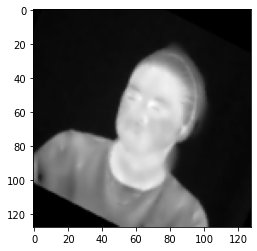

Label: 0


In [6]:
# Print a sample of the training data
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

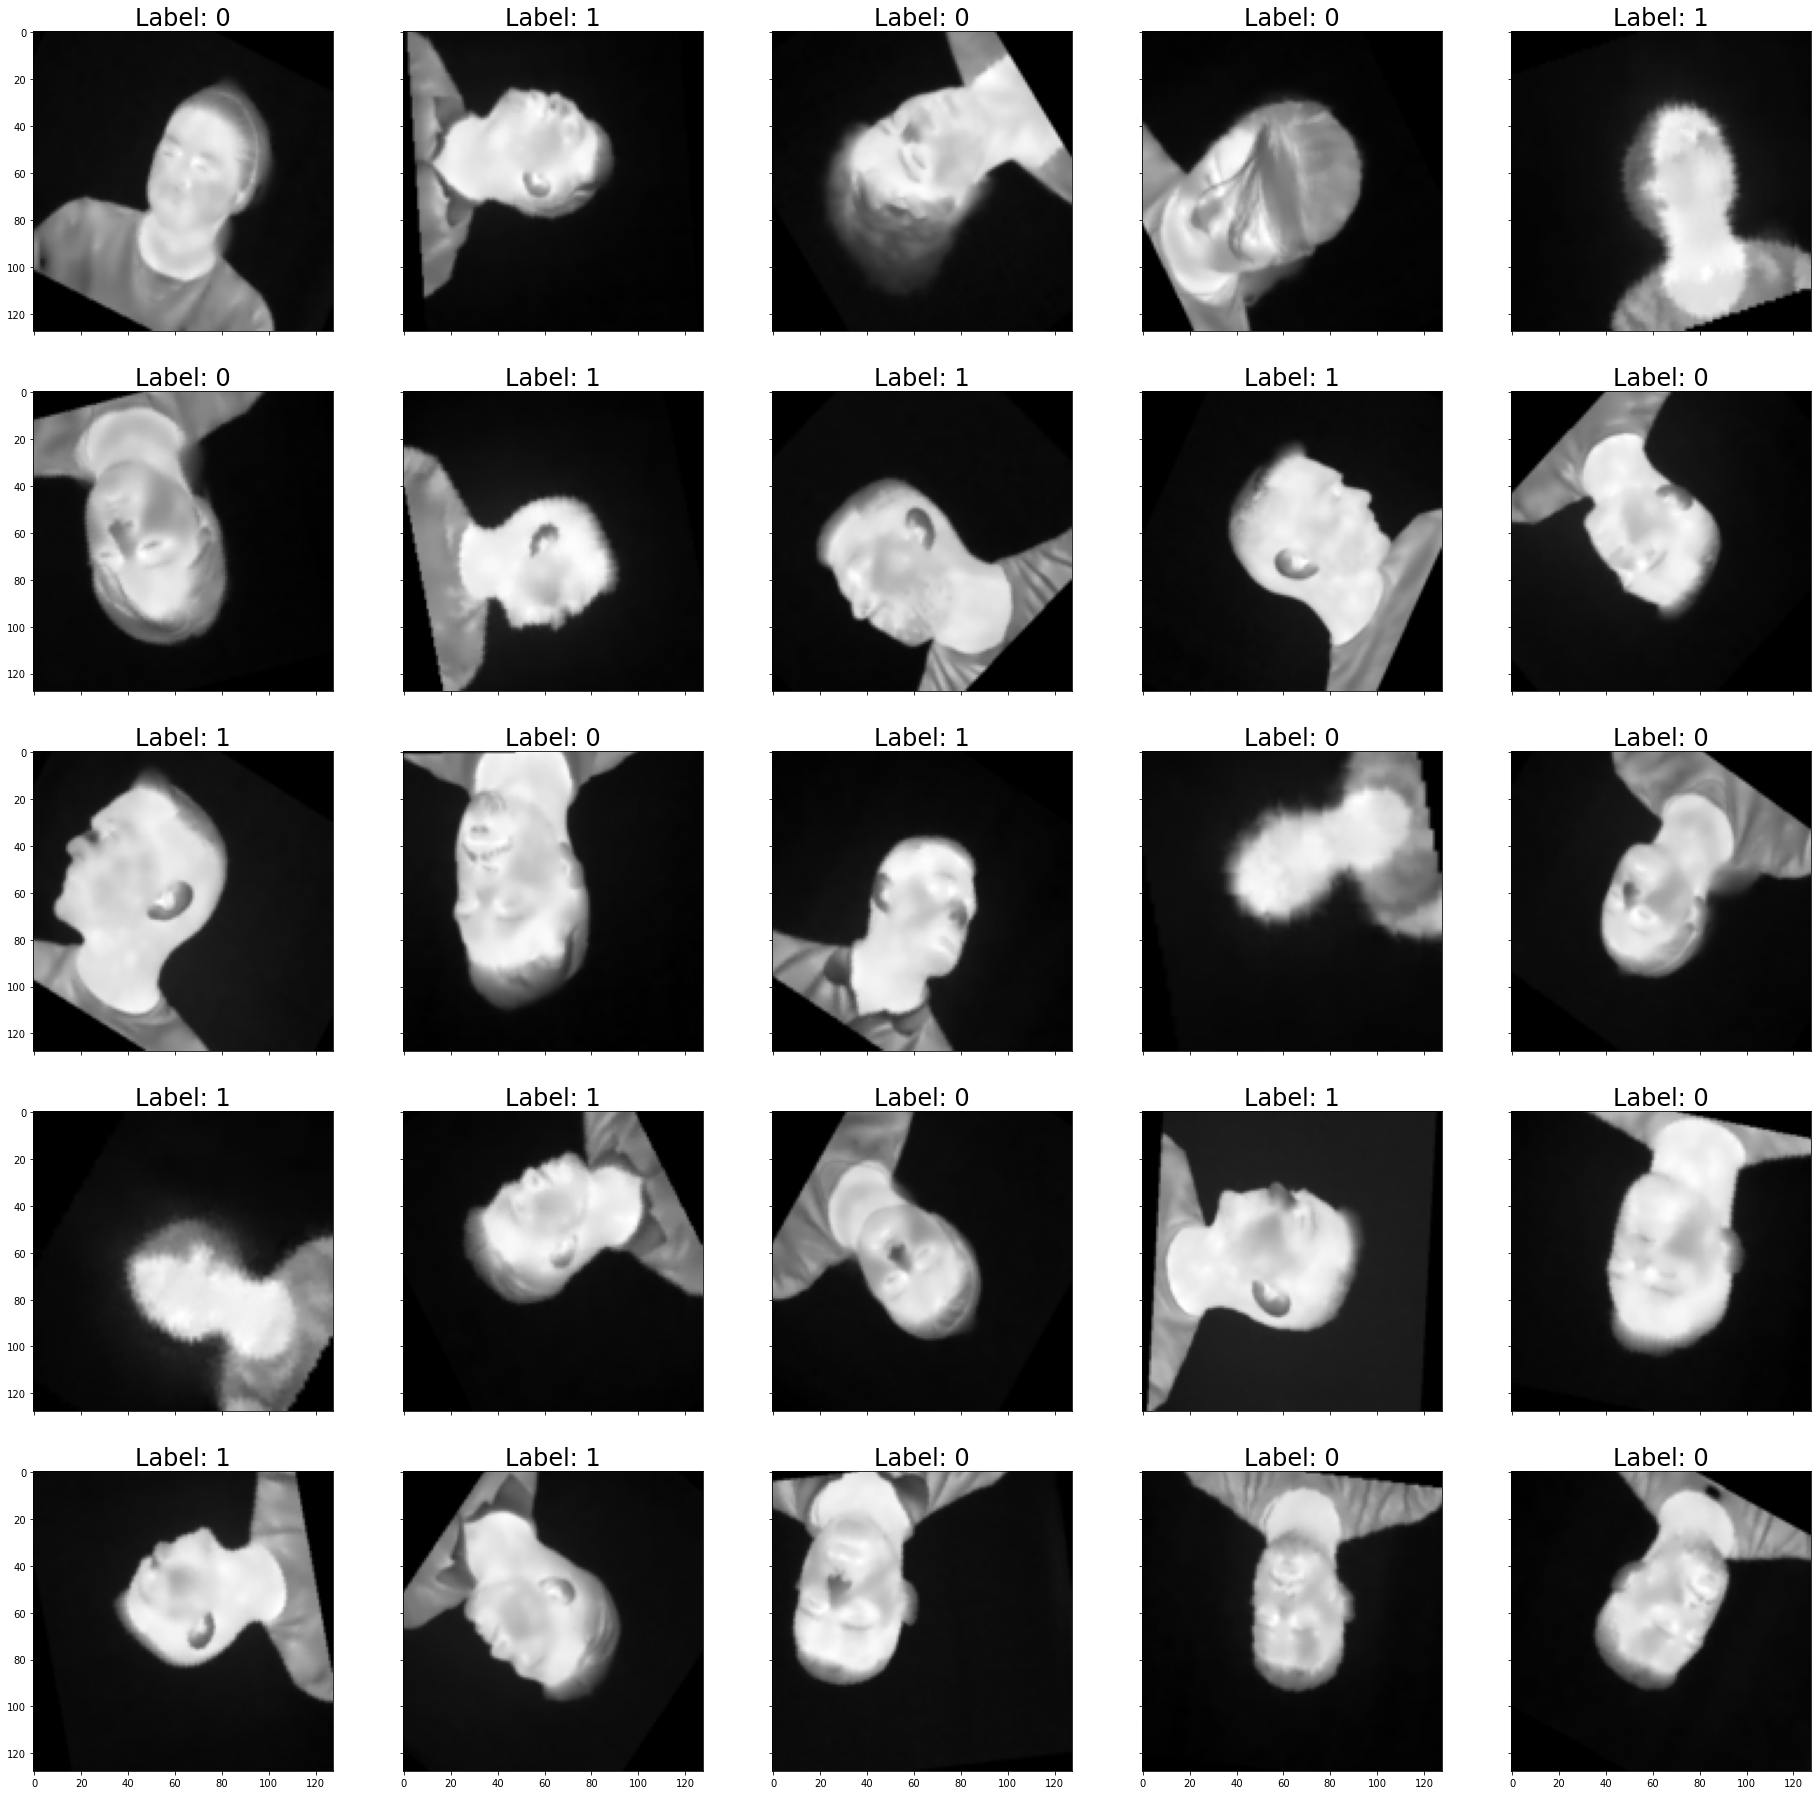

In [7]:
count = 0
l = 5
fig, axs = plt.subplots(l, l)
fig.set_figheight(32)
fig.set_figwidth(32)

for i in range(l):
    for j in range(l):
        img = train_features[count].squeeze()
        label = train_labels[count]

        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].set_title(f"Label: {label}", fontdict={'fontsize': 24})
        
        count +=1

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [8]:
# To verify that our normalization works, we can print out the mean and standard deviation of the single batch.
# The mean should be close to 0 and the standard deviation close to 1 for each channel:
imgs, _ = next(iter(train_loader))
print("Batch mean", imgs.mean(dim=[0,2,3]))
print("Batch std", imgs.std(dim=[0,2,3]))

Batch mean tensor([0.0989])
Batch std tensor([1.0541])


In [9]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(13456, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
# defining the model
model = Net().to(device=device)

    
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [11]:
#Training and validation functions for first model:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in tqdm(range(1, n_epochs + 1)):
        loss_train = 0.0
        for imgs, labels in train_loader:
            
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))
            
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        
# def test(model, test_loader):
#     for name, loader in [("test", test_loader)]:
#         correct = 0
#         total = 0

#         with torch.no_grad():  # <1>
#             for imgs, labels in loader:
#                 imgs = imgs.to(device=device)
#                 labels = labels.to(device=device)
#                 outputs = model(imgs)
#                 _, predicted = torch.max(outputs, dim=1) # <2>
#                 total += labels.shape[0]  # <3>
#                 correct += int((predicted == labels).sum())  # <4>

#         print("Accuracy {}: {:.2f}".format(name , correct / total))

In [12]:
# test(model, test_loader)

In [13]:
class NetDepth(nn.Module): 
  def __init__(self, n_chans1=32):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, 
                           padding=1)
    self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, 
                           kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, 
                           kernel_size=3, padding =1)
    self.fc1 = nn.Linear(4*4*n_chans1 // 2, 32)
    self.fc2 = nn.Linear(32, 2)
  
  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
    out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
    out = out.view(-1, 4*4*self.n_chans1 // 2)
    out = self.fc2(out)
    return out

In [14]:
class NetRes(nn.Module):
  def __init__(self, n_chans1=32):
    super().__init__()
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, 
                           padding=1)
    self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, 
                           kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, 
                           kernel_size=3, padding=1)
    self.fc1 = nn.Linear(4*4*n_chans1 // 2, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
    out1 = out
    out = F.max_pool2d(torch.relu(self.conv3(out)) + out1,
                       2)
    out = out.view(-1, 4*4*self.n_chans1 // 2)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return out


In [15]:
class ResBlock(nn.Module):
  def __init__(self, n_chans):
    super(ResBlock, self).__init__()
    self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, 
                          padding=1, bias=False)
    self.btach_norm = nn.BatchNorm2d(num_features=n_chans)
    torch.nn.init.kaiming_normal_(self.conv.weight, 
                                  nonlinearity='relu')
    #torch.nn.init.constant_(self.batch_norm.weight, 0.5)
    #torch.nn.init.zeros_(self.batch_norm.bias)

  def forward(self, x):
    out = self.conv(x)
    out = self.batch_norm(out)
    out = torch.relu(out)
    return out + x

In [16]:
class ResNet25(nn.Module): 
  def __init__(self, n_chans1=32, n_blocks=50):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.resblocks = nn.Sequential(
        *(n_blocks * [ResBlock(n_chans=n_chans1)]))
    #self.conv1_dropout = nn.Dropout2d(p=0.3)
    self.fc1 = nn.Linear(8*8*n_chans1, 32)
    self.fc2 = nn.Linear(32,2)

  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = self.resblocks(out)
    out = F.max_pool2d(out, 2)
    out = out.view(-1, 8*8*self.n_chans1)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return out

In [17]:
model = ResNet25()
model.to('cuda:0')

ResNet25(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resblocks): Sequential(
    (0): ResBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (btach_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (btach_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ResBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (btach_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ResBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (btach_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): ResBlock(


In [18]:
train_loader = torch.utils.data.DataLoader(train_set, 
                    batch_size=64, shuffle=True)

model = Net().to('cuda:0')
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs =300,
    optimizer= optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    
)

  0%|          | 0/600 [00:00<?, ?it/s]

2022-05-11 10:52:13.429674 Epoch 1, Training loss 1.1814432943739541
2022-05-11 10:54:06.842198 Epoch 10, Training loss 0.6824035237475139
2022-05-11 10:56:12.639381 Epoch 20, Training loss 0.650411671254693
2022-05-11 10:58:18.510449 Epoch 30, Training loss 0.6169476392792492
2022-05-11 11:00:23.512914 Epoch 40, Training loss 0.5928078599092437
2022-05-11 11:02:29.290046 Epoch 50, Training loss 0.5455689800948631
2022-05-11 11:04:36.493217 Epoch 60, Training loss 0.5499368048295742
2022-05-11 11:06:42.790708 Epoch 70, Training loss 0.5263036663939313
2022-05-11 11:08:47.367939 Epoch 80, Training loss 0.5166477859020233
2022-05-11 11:10:51.796753 Epoch 90, Training loss 0.505560345039135
2022-05-11 11:12:56.494592 Epoch 100, Training loss 0.49062223841504354
2022-05-11 11:15:01.576068 Epoch 110, Training loss 0.4819250252188706
2022-05-11 11:17:07.148112 Epoch 120, Training loss 0.45854486197960087
2022-05-11 11:19:12.254483 Epoch 130, Training loss 0.45943988314489037
2022-05-11 11:21

In [19]:
train_loader = torch.utils.data.DataLoader(train_set, 
                    batch_size=64, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_set, 
                        batch_size=64, shuffle=False)

validate(model, train_loader, val_loader)

Accuracy train: 0.86
Accuracy val: 0.72


This is true [1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0
 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 1 0 0 1 1 1 1 0 0]
Predictions [0 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0
 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0]


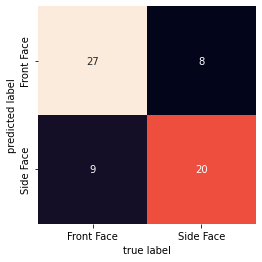

In [27]:
test_features, test_labels = next(iter(val_loader))
model_out = model(test_features.to(device=device))
ytrue = test_labels
ypred = torch.argmax(model_out, axis =1)
ytrue = ytrue.to('cpu').detach().numpy()
ypred = ypred.to('cpu').detach().numpy()
print("This is true", ytrue)
print("Predictions",ypred)
from sklearn.metrics import confusion_matrix 
import seaborn as sns 
mat = confusion_matrix(ytrue, ypred) 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['Front Face','Side Face'], 
            yticklabels=['Front Face','Side Face',]) 
plt.xlabel('true label') 
plt.ylabel('predicted label'); 

In [29]:
import pickle

model_filename = "My_KNN_model.sav"

saved_model = pickle.dump(knn, open(model_filename,'wb'))

print('Model is saved into to disk successfully Using Pickle')

NameError: name 'knn' is not defined